# Monte Carlo simulator
By: Magnus Kvåle Helliesen

# *** *Under construction* ***

In [133]:
import pandas as pd
import numpy as np
from numpy.linalg import eig, inv
import matplotlib.pyplot as plt
import yfinance as yf
from arch import arch_model

Suppose we have a matrix of data
$\boldsymbol{X}=(\boldsymbol{x}_0, \boldsymbol{x}_1, \ldots, \boldsymbol{x}_{N-1})$,
where
$\boldsymbol{x}_i=\{x_{i, t}\}_{t=0}^{T-1}$
is a vector representing the timeseries for some $i$ (maybe a stock ticker or something).

The aim of this notebook is to use eigen decomposition to generate $N$ independent/orthogonal disturbances, normalize these using a GARCH-model (so there is no heteroskedasticity), and draw from the resulting distributions to perform a MonteCarlo-like simulation of the input data.

In [134]:
# Class to be built
class MonteCarlo():
    def __init__(self, df: pd.DataFrame):
        self._df = df

    @property
    def df(self):
        return self._df

    def fit(self):
        # Deep copying DataFrame and calculating covariance matrix
        df_orthongonal_disturbances = self.df.copy(deep=True)
        array = df_orthongonal_disturbances.to_numpy()
        covariance_matrix = np.cov(array.T)

        # Calculating eigenvalues and vectors from covariance matrix
        eigen_values, eigen_vectors = eig(covariance_matrix)
        eigen_values = np.diag(eigen_values)
        
        # Calculating weights and orthogonal disturbances with unit variance
        combination_matrix = (eigen_values**0.5).dot(eigen_vectors.T)
        array[:, :] = array.dot(inv(combination_matrix))

        # Renaming columns
        df_orthongonal_disturbances.columns = [i for i in range(len(df_orthongonal_disturbances.columns))]

        # Setting up GARCH-model for each orthogonal disturbance
        garch_models = {i: arch_model(df_orthongonal_disturbances[i], vol='garch', p=1, o=0, q=1, rescale=False)
                  for i in df_orthongonal_disturbances.columns}

        # Calculating model fits
        garch_fits = {i: model.fit(disp='off') for i, model in garch_models.items()}

        # Calcutating conditional volatility
        df_conditional_volatility = pd.DataFrame()
        for i in range(len(df_orthongonal_disturbances.columns)):
            df_conditional_volatility[i] = garch_fits[i].conditional_volatility

        # calculating orthogonal disturbances normalized by GARCH standard deviation
        df_normalized_orthogonal_disturbances = df_orthongonal_disturbances/df_conditional_volatility

        # Not sure this is the way to go
        self._scaling_matrix = combination_matrix
        self._df_orthogonal_disturbances = df_orthongonal_disturbances
        self._df_normalized_orthogonal_disturbances = df_normalized_orthogonal_disturbances
        self._garch_models = garch_models
        self._garch_fits = garch_fits

        # Returning MonteCarloFit object
        return MonteCarloFit(self)

# Class to be built
class MonteCarloFit():
    def __init__(self, MonteCarlo: MonteCarlo):
        self._MonteCarlo = MonteCarlo

    @property
    def scaling_matrix(self):
        return self._MonteCarlo._scaling_matrix

    @property
    def df_orthogonal_disturbances(self):
        return self._MonteCarlo._df_orthogonal_disturbances

    @property
    def df_normalized_orthogonal_disturbances(self):
        return self._MonteCarlo._df_normalized_orthogonal_disturbances


# Use MonteCarlo class

In [135]:
# Function that fetches data
def fetch_data(tickers: tuple):
    data = {}
    for ticker in tickers:
        data[ticker] = yf.Ticker(ticker).history(period='max')

    # Returning transformed data
    return (
        pd.concat(data)[['Close']]
        .reset_index()
        .rename(columns={'level_0': 'Ticker'})
        .pivot(index='Date', columns='Ticker', values='Close')
    )

tickers = ('NHY.OL', 'DNB.OL', 'YAR.OL', 'NAS.OL', 'TEL.OL', 'FRO.OL')
df_orthongonal_disturbances = fetch_data(tickers).dropna()
df_orthongonal_disturbances

Ticker,DNB.OL,FRO.OL,NAS.OL,NHY.OL,TEL.OL,YAR.OL
Date,,,,,,
2004-03-25 00:00:00+01:00,17.060759,668.643738,1216.948120,10.377870,18.962238,22.093435
2004-03-26 00:00:00+01:00,17.216925,670.436218,1199.807983,10.389772,19.238768,22.526642
2004-03-29 00:00:00+02:00,17.255964,702.703064,1216.948120,10.330267,19.712822,21.985138
2004-03-30 00:00:00+02:00,17.177881,700.910583,1222.661499,10.246956,18.646196,21.660231
2004-03-31 00:00:00+02:00,17.568291,699.118042,1199.807983,10.282661,18.804222,21.573587
...,...,...,...,...,...,...
2023-10-23 00:00:00+02:00,206.000000,231.600006,7.884000,56.759998,114.199997,361.399994
2023-10-24 00:00:00+02:00,203.899994,236.100006,8.172000,59.680000,113.400002,361.700012
2023-10-25 00:00:00+02:00,200.000000,239.350006,7.880000,59.939999,115.949997,360.200012


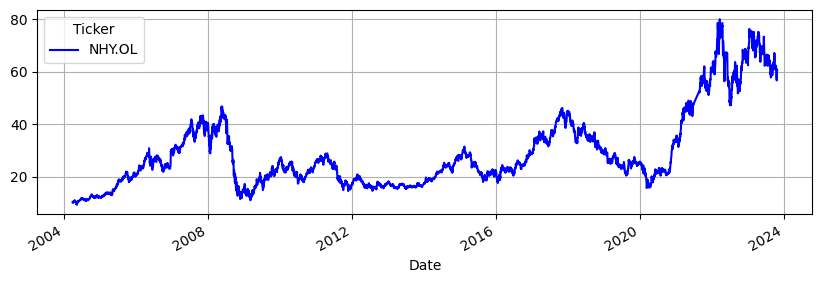

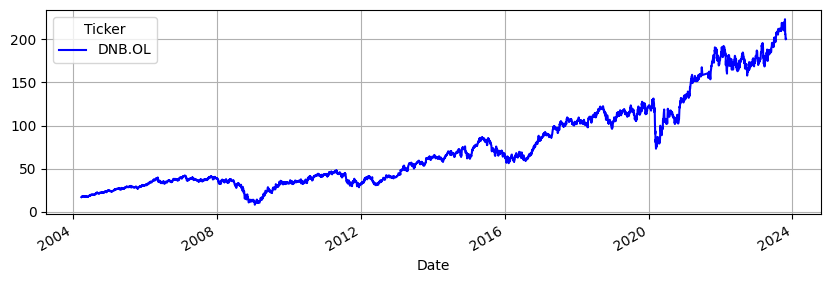

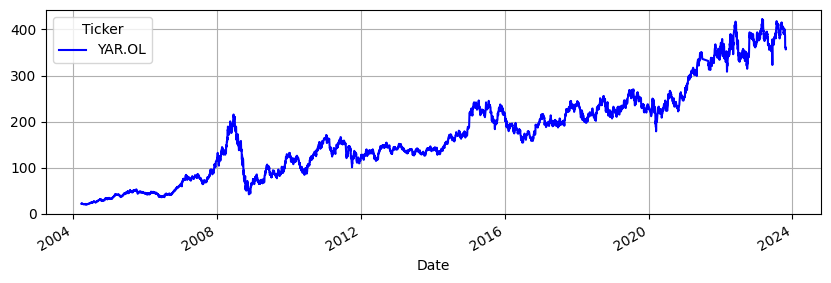

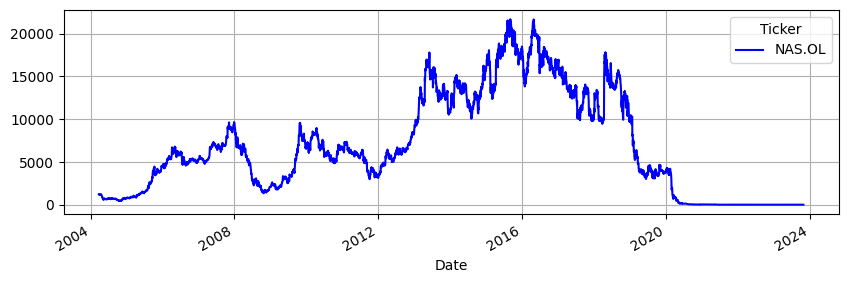

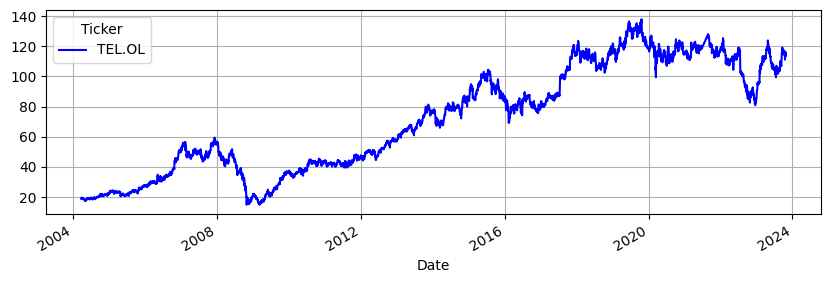

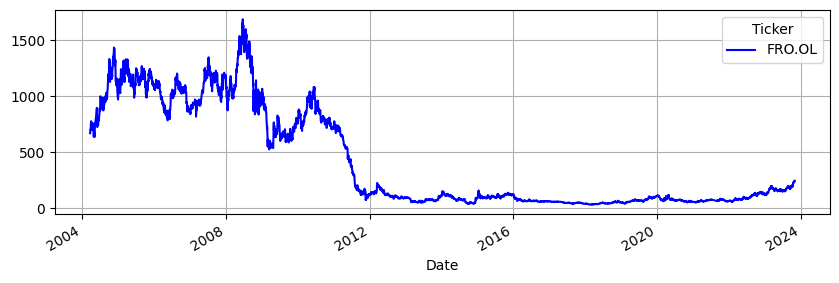

In [136]:
for ticker in tickers:
    df_orthongonal_disturbances[[ticker]].plot(color='b', figsize=(10, 3), grid=True)

In [137]:
# Calculating log-differences and removing first value
df_diff = np.log(df_orthongonal_disturbances).diff().iloc[1:, :]
df_diff

Ticker,DNB.OL,FRO.OL,NAS.OL,NHY.OL,TEL.OL,YAR.OL
Date,,,,,,
2004-03-26 00:00:00+01:00,0.009112,0.002677,-0.014185,0.001146,0.014478,0.019418
2004-03-29 00:00:00+02:00,0.002265,0.047006,0.014185,-0.005744,0.024342,-0.024332
2004-03-30 00:00:00+02:00,-0.004535,-0.002554,0.004684,-0.008097,-0.055627,-0.014889
2004-03-31 00:00:00+02:00,0.022473,-0.002561,-0.018869,0.003478,0.008439,-0.004008
2004-04-01 00:00:00+02:00,-0.011173,0.042666,-0.014389,-0.005804,-0.004211,0.004008
...,...,...,...,...,...,...
2023-10-23 00:00:00+02:00,0.000000,0.008673,-0.004556,-0.021956,-0.013481,-0.000553
2023-10-24 00:00:00+02:00,-0.010247,0.019244,0.035878,0.050165,-0.007030,0.000830
2023-10-25 00:00:00+02:00,-0.019312,0.013671,-0.036386,0.004347,0.022238,-0.004156


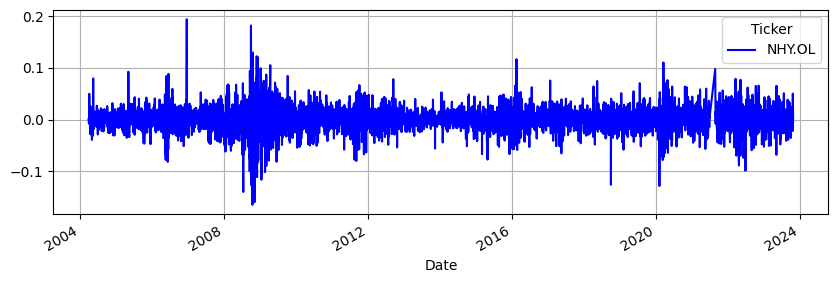

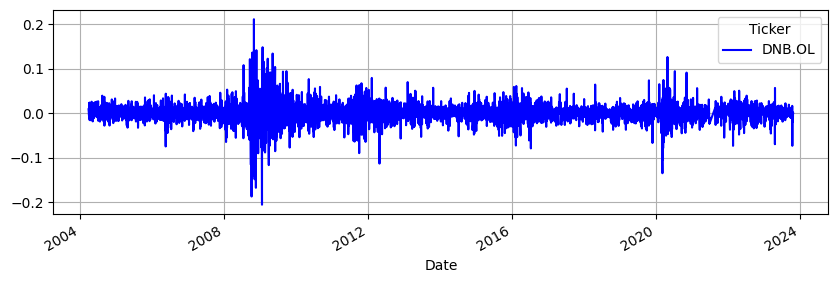

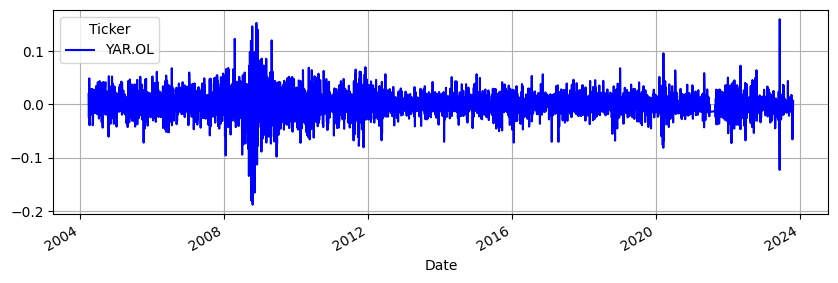

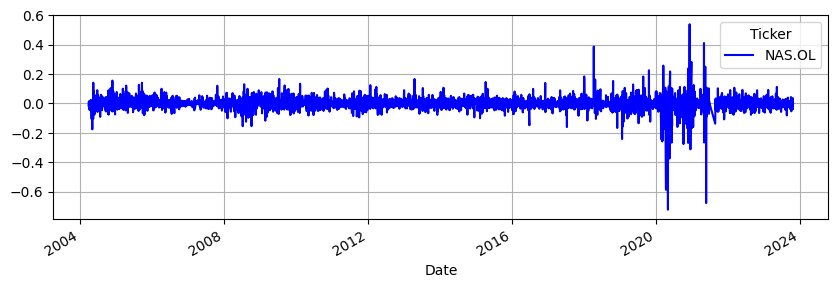

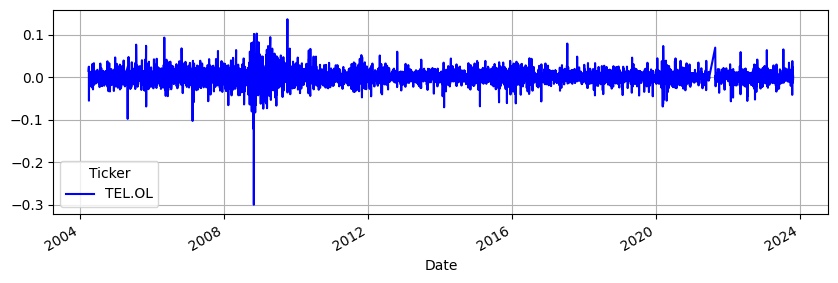

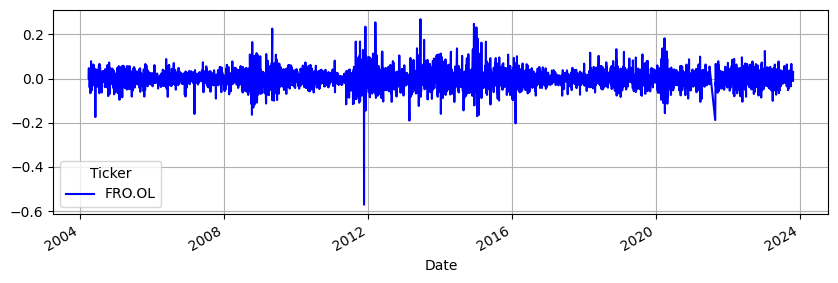

In [138]:
for ticker in tickers:
    df_diff[[ticker]].plot(color='b', figsize=(10, 3), grid=True)

In [139]:
df_diff.corr().style.background_gradient(cmap='Blues')

Ticker,DNB.OL,FRO.OL,NAS.OL,NHY.OL,TEL.OL,YAR.OL
Ticker,,,,,,
DNB.OL,1.000000,0.253422,0.194920,0.482605,0.388664,0.418182
FRO.OL,0.253422,1.000000,0.124735,0.315269,0.197058,0.277839
NAS.OL,0.194920,0.124735,1.000000,0.204137,0.152877,0.167200
NHY.OL,0.482605,0.315269,0.204137,1.000000,0.353360,0.487499
TEL.OL,0.388664,0.197058,0.152877,0.353360,1.000000,0.346859
YAR.OL,0.418182,0.277839,0.167200,0.487499,0.346859,1.000000


In [140]:
model = MonteCarlo(df_diff)
fit = model.fit()

# Okay, the disturbances are orthogonal. This we can work with
fit.df_orthogonal_disturbances.cov().style.background_gradient(cmap='Blues')

,0,1,2,3,4,5
0,1.000000,0.000000,-0.000000,-0.000000,-0.000000,0.000000
1,0.000000,1.000000,0.000000,-0.000000,-0.000000,0.000000
2,-0.000000,0.000000,1.000000,-0.000000,-0.000000,0.000000
3,-0.000000,-0.000000,-0.000000,1.000000,-0.000000,-0.000000
4,-0.000000,-0.000000,-0.000000,-0.000000,1.000000,-0.000000
5,0.000000,0.000000,0.000000,-0.000000,-0.000000,1.000000


In [141]:
# The normalized ones are nearly orthogonal too
fit.df_normalized_orthogonal_disturbances.cov().style.background_gradient(cmap='Blues')

,0,1,2,3,4,5
0,0.999213,0.087850,0.034617,0.022817,0.012703,-0.014241
1,0.087850,1.000073,0.050571,0.014744,0.002642,-0.019294
2,0.034617,0.050571,1.000599,-0.019158,-0.037791,0.049627
3,0.022817,0.014744,-0.019158,1.000848,-0.031126,0.009323
4,0.012703,0.002642,-0.037791,-0.031126,1.000478,0.066501
5,-0.014241,-0.019294,0.049627,0.009323,0.066501,1.000746


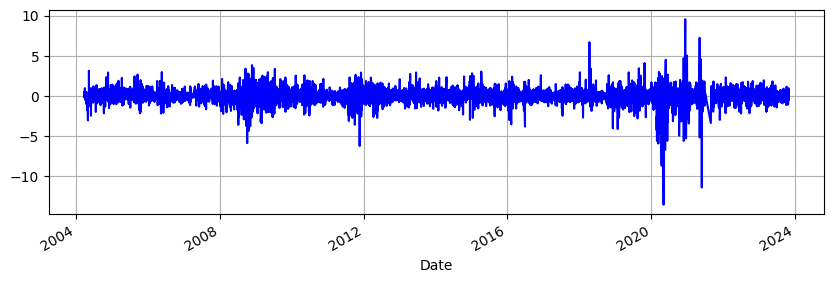

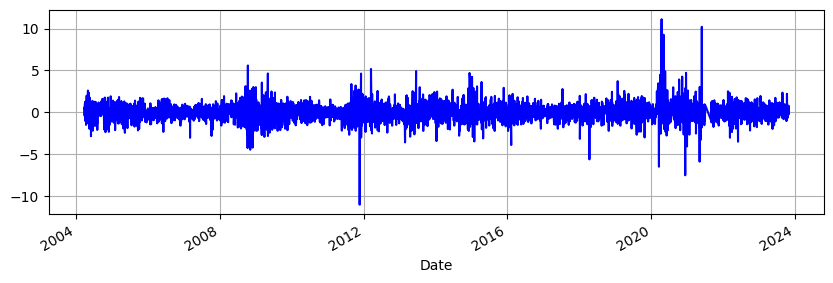

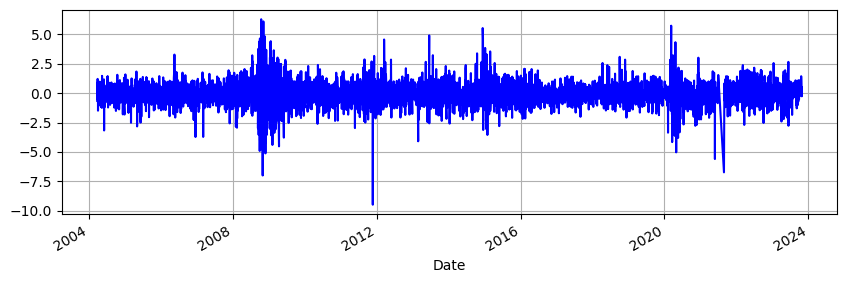

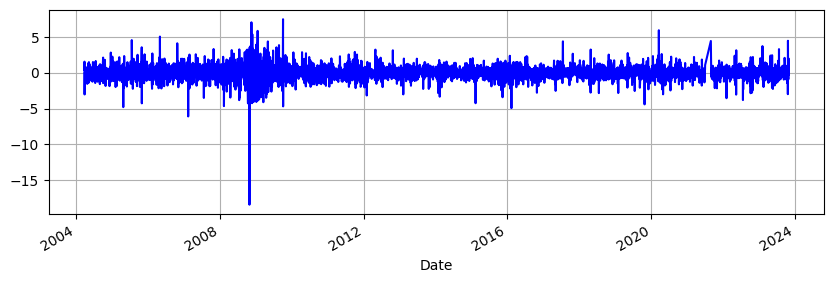

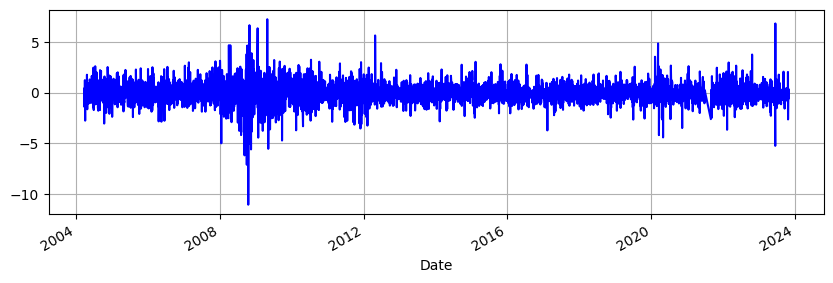

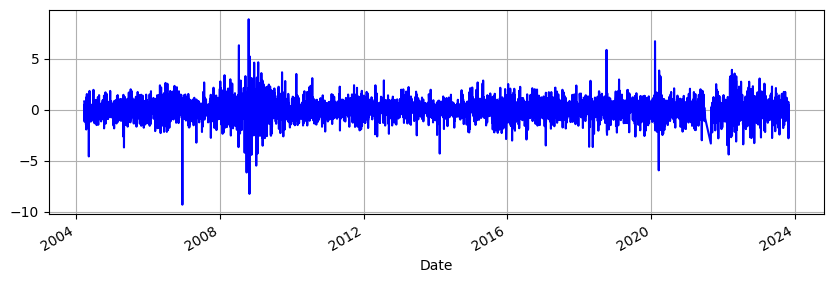

In [142]:
# Orthogonal disturbances
for i in range(len(fit.df_orthogonal_disturbances.columns)):
    plt.figure()
    fit.df_orthogonal_disturbances[i].plot(color='b', figsize=(10, 3), grid=True)
    plt.draw()

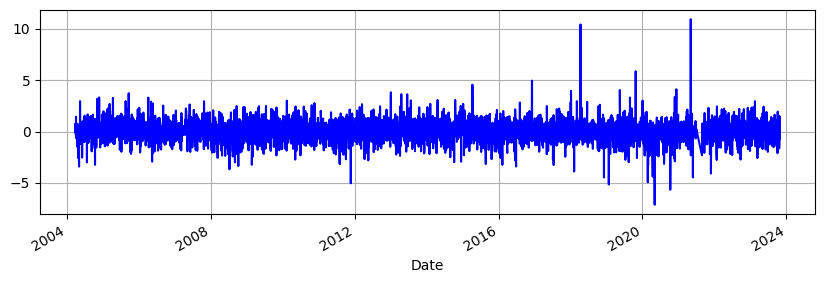

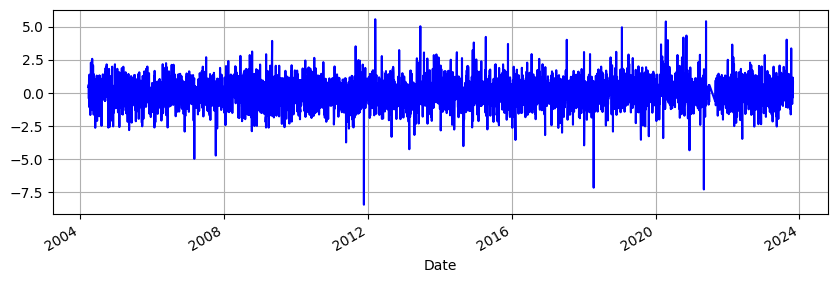

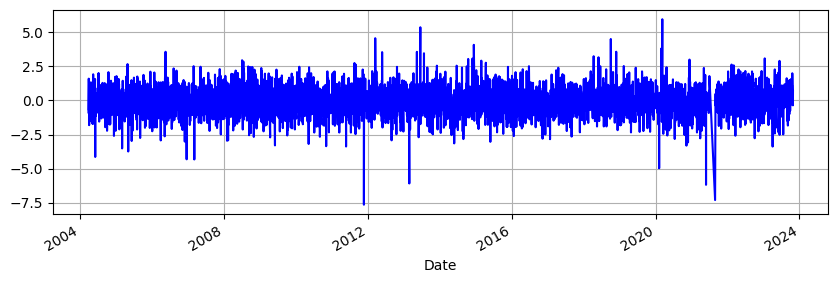

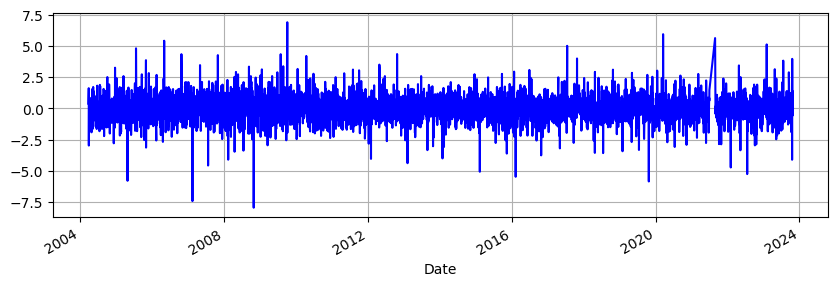

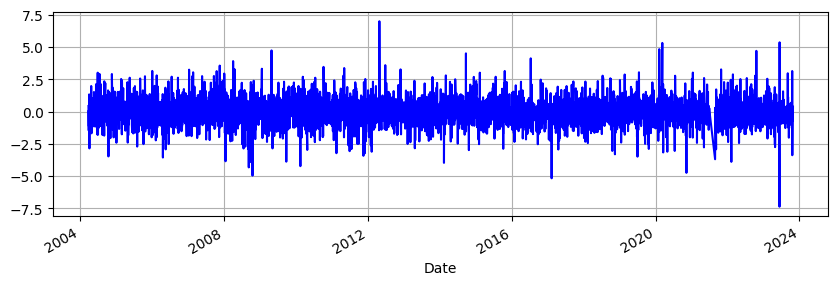

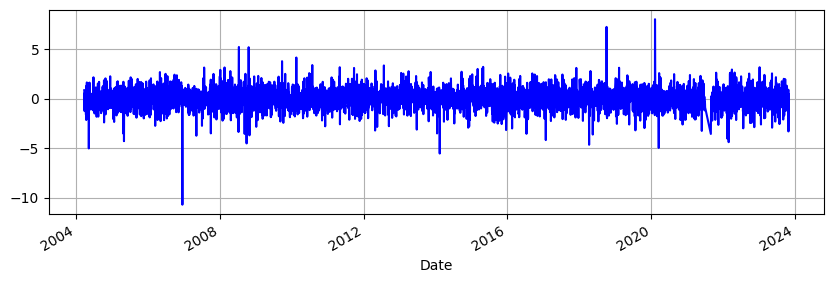

In [143]:
# Orthognal disturbances where heteroskedasticity is removed using GARCH model fits
for i in range(len(fit.df_orthogonal_disturbances.columns)):
    plt.figure()
    fit.df_normalized_orthogonal_disturbances[i].plot(color='b', figsize=(10, 3), grid=True)
    plt.draw()